## Импорт библиотек и данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsp
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.vector_ar.vecm import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_excel('Dannye_unikalnye_posetiteli.xlsx')
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d').dt.to_period('M')
data = data.set_index('date')
data.head()

,rutube,ok,vk,youtube,instagram,facebook,livejournal,tme,tiktok,viber,whatsapp,twitter
date,,,,,,,,,,,,
2020-01,7642615,66071615,136529774,110053050,39109093,32873809,22759998,2395590,4807360,4131704,6979689,12539617
2020-02,6993502,72968412,147940997,114449074,42119092,35625553,23742480,2364717,4919586,5158358,7084874,12419165
2020-03,7436795,65984641,148457726,130521163,41511274,36562912,23045433,2536306,5993411,5261193,9682350,11200586
2020-04,5883683,54722621,122227008,108917174,29654579,26944705,19769076,1754551,4304301,5653152,7512379,6859501
2020-05,5052246,40987553,93085358,67231553,30134636,26503459,16930264,1933490,3571125,3347322,7502547,8050847


<Axes: xlabel='date'>

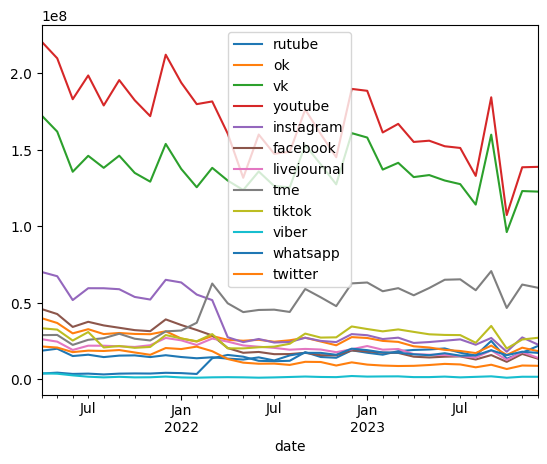

In [8]:
data.iloc[15:, :].plot()

<Axes: xlabel='date'>

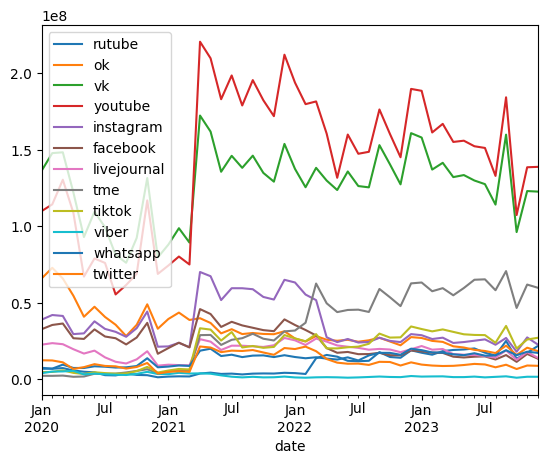

In [9]:
data.plot()

## Проверка стационарности

In [3]:
fuller = data.iloc[0, :].copy()
for i in data.columns:
    fuller[i] = adfuller(data[i])[1]

print('p-value теста Дики-Фулера:')
fuller

p-value теста Дики-Фулера:


rutube         0.939228
ok             0.000721
vk             0.225564
youtube        0.095192
instagram      0.154834
facebook       0.841535
livejournal    0.042480
tme            0.776971
tiktok         0.237908
viber          0.043419
whatsapp       0.125323
twitter        0.173029
Name: 2020-01, dtype: float64

Как видим, почти все ряды являются нестационарными в соответствии с тестом Дики-Фулера. Таким образом, применять в ним векторную авторегрессию VAR нельзя, однако модель векторной коррекции ошибок VECM применима. Однако, для использования VECM необходимо разобраться в коинтегрированности рядов.

## Проверка коинтегрированности

Полезно будет ознакомится с https://www.aptech.com/blog/a-guide-to-conducting-cointegration-tests/

### Тест Йохансона

Для определения глубины лага (это необходимо для тестов Йохансона и Энгла-Гренджера) воспользуемся критериями AIC, BIC, FPE, HQIC

In [3]:
lag_order = select_order(data=data, maxlags=10, deterministic="ci", seasons=0)
lag_order.summary()

,AIC,BIC,FPE,HQIC
0,347.0,354.3,7.793e+150,349.5
1,340.1,353.7,3.060e+149,344.9
2,-30.37,-10.51,0.04050,-23.37
3,-389.1*,-362.9*,7.106e-174,-379.9*
4,-376.6,-344.2,1.414e-174,-365.2
5,-370.7,-332.1,7.386e-177,-357.1
6,-362.4,-317.4,1.588e-177,-346.5
7,-352.9,-301.7,1.840e-177,-334.9
8,-349.8,-292.3,5.486e-180,-329.6
9,-340.4,-276.7,1.132e-179,-317.9


Как видим, в соответствии с информационными критериями глубина лага для всего набора данных $\rho - 1=3 \rightarrow \rho=4$

In [4]:
johansen_test = coint_johansen(endog=data,
                               det_order=1, # линейный тренд
                               k_ar_diff=4 # глубина лага
                              )
r = (johansen_test.lr2 > johansen_test.cvm[:, 1]).sum()
r

6

Как видим, число коинтегрированных веткоров в соответствии со статистикой максимальных собственных значений Йохансона равно шести ($r=6$). Таким образом, число коинтегрированных пар $r<K$, где $K=12$ - общее количество регрессоров. В такой ситуации, действительно, можно применять модель VECM. 

Однако, для интереса также рассмотрим и матрицу коинтеграции конкретных процессов.

### Тест Энгла-Гренджера

Гипотезы:

$H_0$: коинтеграции между двумя рядами нет

$H_1$: коинтеграция между двумя рядами есть

In [6]:
coint_data = data.corr().copy() * 0
for i in data.columns:
    for j in data.columns[data.columns != i]:
        p_value = coint(y0 = data[i],
                        y1 = data[j],
                        trend = 'ct', # постоянный и линейный тренд
                        autolag = 'AIC'
                       )[1]
        coint_data[i][j] +=  np.round(p_value, 2)

In [130]:
mask = ((np.triu(np.ones_like(coint_data)) - 1 ) * - 1) * coint_data
mask

,rutube,ok,vk,youtube,instagram,facebook,livejournal,tme,tiktok,viber,whatsapp,twitter
rutube,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.0
ok,0.04,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.0
vk,0.24,0.99,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.0
youtube,0.45,0.03,0.18,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.0
instagram,0.00,0.01,0.35,0.70,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.0
facebook,0.01,0.02,0.59,0.98,0.45,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.0
livejournal,0.12,0.99,0.06,0.34,0.61,0.83,-0.00,-0.00,-0.00,-0.00,-0.00,-0.0
tme,0.80,0.98,0.06,0.55,0.66,0.76,0.07,-0.00,-0.00,-0.00,-0.00,-0.0
tiktok,0.52,0.01,0.01,0.48,0.52,0.93,0.05,0.07,-0.00,-0.00,-0.00,-0.0
viber,0.04,0.10,0.57,0.08,0.10,0.82,0.06,0.00,0.07,-0.00,-0.00,-0.0


Text(0.5, 1.0, 'Матрица p-value теста попарной коинтегрированности')

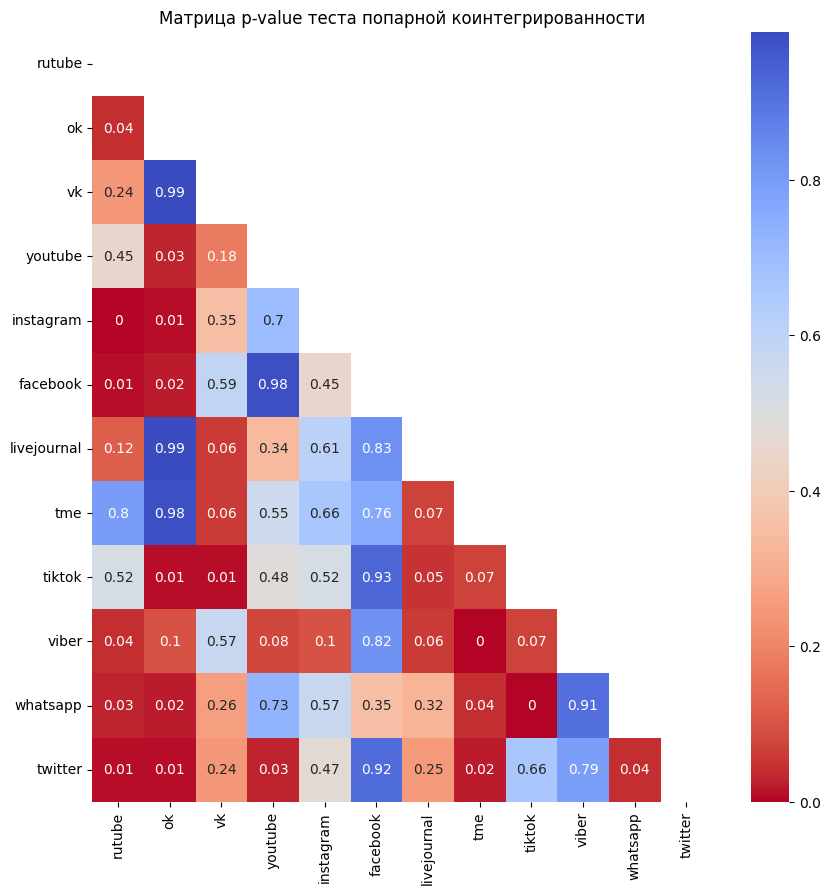

In [133]:
plt.figure(figsize=[10, 10])

mask = np.triu(np.ones_like(coint_data))
diverging_colors = sns.color_palette("coolwarm_r", as_cmap=True)
sns.heatmap(coint_data, annot=True, cmap=diverging_colors, mask=mask)
plt.title('Матрица p-value теста попарной коинтегрированности')

Как видим, большая часть процессов попарно коинтегрированны.

## Строим VECM ♿

Полезно будет ознакомиться с https://spureconomics.com/vector-error-correction-vecm-theory/

Для удобства построим модель на коинтегрированной троице рядов RuTube, OKRU, Livejournal. Для этого вновь рассчитаем глубину лагирования. Возьмем критерий FPE=5 для того, чтобы результаты были покороче.

In [5]:
lag_order = select_order(data=data[['rutube', 'ok', 'livejournal']], maxlags=10, deterministic="ci", seasons=0)
lag_order.aic, lag_order.bic, lag_order.fpe, lag_order.hqic

(10, 10, 5, 10)

Теперь определим ранг коинтеграции

In [6]:
rank_test = select_coint_rank(endog=data[['rutube', 'ok', 'livejournal']],
                              det_order=0, # нет тренда, есть константа
                              k_ar_diff=lag_order.fpe + 1, # глубина лага
                              method="trace", 
                              signif=.05 # уровень значимости
                             )
rank_test.summary()

r_0,r_1,test statistic,critical value
0,3,33.32,29.80
1,3,11.23,15.49


Ранг коинтеграции VECM равен 1.

Теперь, наконец построим VECM.

In [7]:
model = VECM(endog=data[['rutube', 'ok', 'livejournal']], 
             deterministic="cilo", # спецификация линейного тренда снаружи коинтеграционной зависимости 
             k_ar_diff=lag_order.fpe, # глубина лагов
             coint_rank=rank_test.rank # ранг коинтеграции
            ).fit()
print(model.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation rutube
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
lin_trend       3.873e+04   1.78e+05      0.218      0.827   -3.09e+05    3.87e+05
L1.rutube         -0.5036      0.186     -2.714      0.007      -0.867      -0.140
L1.ok             -0.1168      0.190     -0.616      0.538      -0.489       0.255
L1.livejournal    -0.0115      0.202     -0.057      0.954      -0.407       0.384
L2.rutube         -0.4319      0.189     -2.282      0.022      -0.803      -0.061
L2.ok             -0.0219      0.139     -0.158      0.874      -0.294       0.250
L2.livejournal    -0.0405      0.176     -0.230      0.818      -0.385       0.304
L3.rutube         -0.1051      0.217     -0.484      0.628      -0.530       0.320
L3.ok              0.0501      0.114      0.439      0.660      -0.173       0.274
L

Здесь мы можем видеть оценку VECM модели. Коэффициенты демонстрируют зависимость процессов в краткосрочной перспективе, при этом взаимосвязь 
коинтеграции/равновесия долгосрочная.

Интерпретировать коэффициенты модели нужно следующим образом, на примере rutube:

Первые таблицы показывают набор коэффициентов перед лагированными переменными. В модели VECM эти коэффициенты являются *краткосрочными*, если быть точнее, они показывают реакцию процессов на отклонение процесса (этого же или другого) от долгосрочного равновесия. Если $L_i \in [-1, 0]$, то мы наблюдаем подстановку процесса, которая отдаляет нас от неравновесия (после увеличения одной из переменных на 1) к равновесию, притом движение к равновесию быстрее при $L_i \rightarrow -1$. Если $L_i \in (-\infty, -1)$, то мы наблюдаем чрезмерную реакцию процесса, которая отдаляет нас от равновесия после шока одной из переменных. Если $L_i \in (0, +\infty)$, то мы наблюдаем отклонение и уход от равновесия.

Например, **Таблица Det. terms outside the coint. relation & lagged endog. parameters for equation ok**. Проинтепретируем значимые коэффициенты ($p value<0.05$), $L1_{rutube} = -0.6962$ означает, что при изменении числа уникальных посетителей сайта RuTube в прошлом месяце на 1 число посетителей сайта OKRU в среднем изменяется на -0.6962 и таким образом стремится к прежнему равновесию. $L1_{livejournal} = 0.5215$ означает, что при увеличении числа посетителей сайта LiveJournal в прошлом месяце на 1 число посетителей сайта OKRU в среднем изменяется на +0.5215 и тем самым медленно отдаляетя от долгосрочного равновесия. $L1_{ok} = 0.2397$ означает, что при росте числа посетителей сайта OKRU в позапрошлом месяце на 1 число посетителей сайта в этом месяце изменяется в среднем на +0.2397 и тем самым медленно отдаляется от равновесия. И так далее...

Далее, в таблицах помеченных (alpha) показываются коэффициенты краткосрочной корректировки. Они показывают подстановку процессов на пути между разными равновесиями. Если $\alpha_i \in [-1, 0]$, то процессы в ответ на увеличение равновесия в коинтегрированной паре на 1 стремятся к предыдущему равновесию, если же $\alpha_i \in (-\infty, -1) \cup (0, +\infty)$, то процессы в ответ стремятся к новому равновесию. 

Например, **Таблица Loading coefficients (alpha) for equation ok** показывает, что серднее число посетителей OKRU возрастает на 0.5211 в ответ на рост долгосрочного числа посетителей в коинтегрированной паре на 1 (в данном случае она одна, но в целом их может быть несколько, если ввести высший ранг коинтеграции, и тогда число таблиц параметров $\alpha$ и $\beta$ будет расти). И так далее...

Далее, в таблице для коэффициента $\beta$ показываются коэффициенты долгосрочной связи переменных. Иначе, это "эластичность" переменных в модели. В ответ на увеличение равновесного числа посетителей RuTube в прошлом периоде в коинтегрированной паре на 1 в долгосрочной перспективе число посетителей RuTube увеличится на 1 (так как это новое равновесие). В ответ на то же увеличение число пользователей OKRU сократится на -2.5817 в долгосрочной перспективе. И так далее...

Вот как можно визуально проверять остатки. Я также рассчитаю, например, RMSE, однако данный покзаатель надо считать для прогнозов на выборке, которая не использовалась при построении модели, как я и писал в сообщении. Здесь я считаю RMSE, чтобы показать как это делается. $$\Large RMSE = \sqrt{\sum^n_{i=1}\frac{(\hat{y_i}-y_i)^2}{n}}$$ Составляющая $\hat{y_i}-y_i$ как раз и является остатками $resid$.

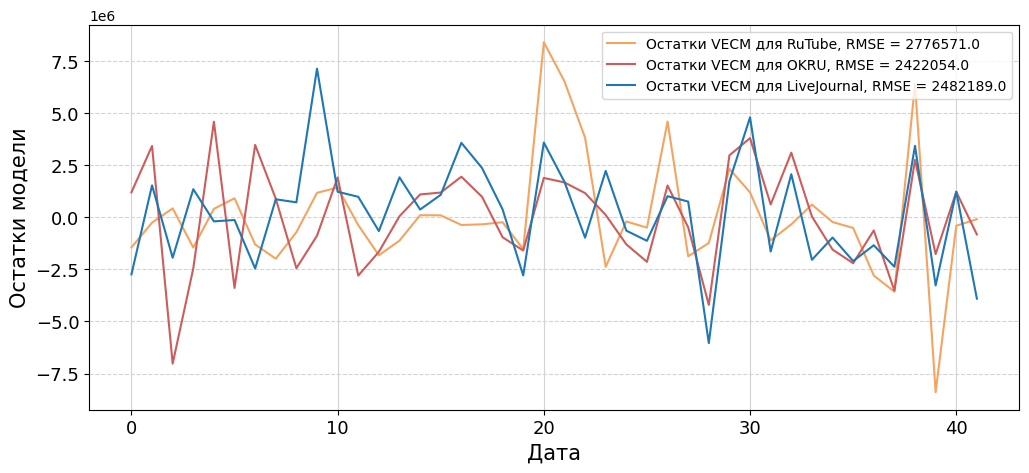

In [29]:
plt.figure(figsize = [12, 5])

plt.plot(model.resid[:, 0], color='sandybrown', 
         label=f'Остатки VECM для RuTube, RMSE = {np.round(np.sqrt(np.sum(model.resid[:, 0] ** 2) / len(model.resid[:, 0])))}')
plt.plot(model.resid[:, 1], color='indianred', 
         label=f'Остатки VECM для OKRU, RMSE = {np.round(np.sqrt(np.sum(model.resid[:, 1] ** 2) / len(model.resid[:, 1])))}')
plt.plot(model.resid[:, 2], color='C0', 
         label=f'Остатки VECM для LiveJournal, RMSE = {np.round(np.sqrt(np.sum(model.resid[:, 2] ** 2) / len(model.resid[:, 2])))}')

plt.xlabel('Дата', fontsize = 15, color='black')
plt.ylabel('Остатки модели', fontsize = 15, color='black')
plt.grid(axis ='x', which='major', linestyle='-', color='lightgrey')
plt.grid(axis ='y', which='major', linestyle='--', color='lightgrey')
plt.tick_params(axis='x', labelsize=13, color='black')
plt.tick_params(axis='y', labelsize=13)
#plt.title('Остатки в модели VECM')
plt.legend()

Получим прогноз модели. В идеале для этого нужно разбить выборку на обущающую и тестову, но я это делаю чисто для понимания механизма, поэтому *и так сойдет*

In [35]:
fc = model.predict(steps=5, alpha=0.1)
fc[0].shape

(5, 3)

Объект forecast fc состоит из трех матриц. Первая из них fc[0] содержит точечные прогнозы на 5 периодов для трех переменных, поэтому ее размер [5, 3]. Второй объект fc[1] содержит нижний интервальный прогноз, fc[3] верхний интервальный прогноз для 5 периодов 3х переменных соответственно. Для примера сделаю прогноз посетителей одноклассников OKRU.

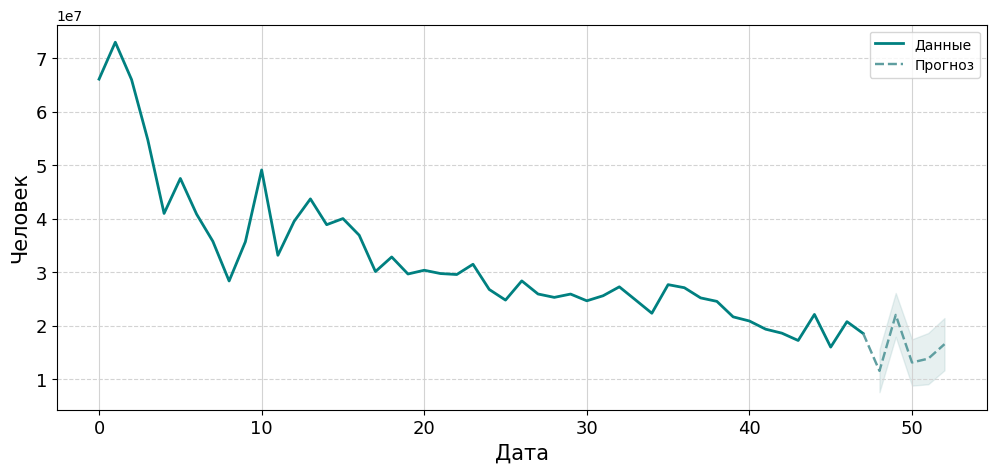

In [55]:
y_hat = fc[0][:, 1]
y_hat = np.insert(y_hat, 0, data['ok'][-1])
lower_series = fc[1][:, 1]
upper_series = fc[2][:, 1]

dayss = np.arange(len(data)-1, len(data) + 5, 1)
days = np.arange(len(data), len(data) + 5, 1)

plt.figure(figsize = [12, 5])

plt.plot(data['ok'].values, color='teal', linewidth=2, label = "Данные")
plt.plot(dayss, y_hat, color='cadetblue', linestyle='--', linewidth=1.75, label='Прогноз')
plt.fill_between(days, lower_series, upper_series,
                 color='cadetblue', alpha=.15)
         
plt.xlabel('Дата', fontsize = 15, color='black')
plt.ylabel('Человек', fontsize = 15, color='black')
plt.grid(axis ='x', which='major', linestyle='-', color='lightgrey')
plt.grid(axis ='y', which='major', linestyle='--', color='lightgrey')
plt.tick_params(axis='x', labelsize=13, color='black')
plt.tick_params(axis='y', labelsize=13)
#plt.title('Прогноз в модели VECM')
plt.legend()